# 配置

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib as mpl
from arch import arch_model
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体   
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题
p = print

# 数据

In [2]:
# tushare数据
import tushare as ts
ts.set_token('c5e635f32d3b7a8f1168362b0ca87988454155e835a5fd9ce5b43e38')
tp= ts.pro_api()
end=None
start='20100101'
# 获取相关指数的行情数据
get_px=lambda x:tp.index_daily(ts_code=x,start_date=start,end_date=end)['close']
symbols={'hs300':'399300.SZ','sz50':'000016.SH','zxb':'399005.SZ'}
data=pd.DataFrame(data={k:get_px(v) for k,v in symbols.items()})
data.index=pd.to_datetime(tp.index_daily(ts_code="399300.SZ",start_date=start,end_date=end)['trade_date'])
data.sort_index(ascending=True,inplace=True)
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [3]:
data.head()

,hs300,sz50,zxb
trade_date,,,
2011-06-13,2950.348,1945.720,5588.077
2011-06-14,2993.559,1970.099,5658.383
2011-06-15,2963.119,1952.076,5597.467
2011-06-16,2917.578,1927.047,5486.554
2011-06-17,2892.157,1912.379,5439.377


In [4]:
lrets.tail()

,hs300,sz50,zxb
trade_date,,,
2018-10-29,-0.030959,-0.032660,-0.023656
2018-10-30,0.010787,0.010852,0.002885
2018-10-31,0.013909,0.014578,0.015323
2018-11-01,0.007332,0.003682,0.015485
2018-11-02,0.035014,0.033026,0.046135


# 构造时间序列特征分析绘图函数

In [5]:
def tsplot(y, lags=30, figsize=(8, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('时间序列分析')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05,title='自相关系数')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05,title='偏自相关系数')
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()
    return 

# 白噪声
白噪声是我们需要了解的第一个时间序列模型（TSM）。根据定义，作为白噪声过程的时间序列具有连续不相关的误差，并且这些误差的预期平均值等于零。

<IPython.core.display.Javascript object>


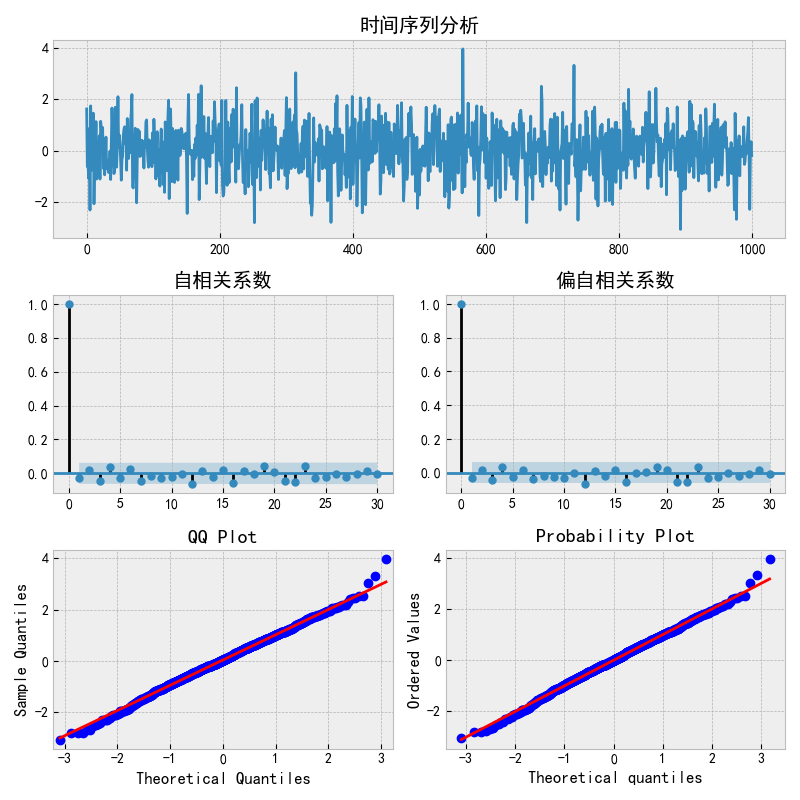

In [6]:
np.random.seed(1)
# 绘制白噪声时间序列
randser=np.random.normal(size=1000)
tsplot(randser,lags=30)

# 随机游走
$x_t=x_{t-1}+w_t，w_t$是一个白噪声时间序列

<IPython.core.display.Javascript object>


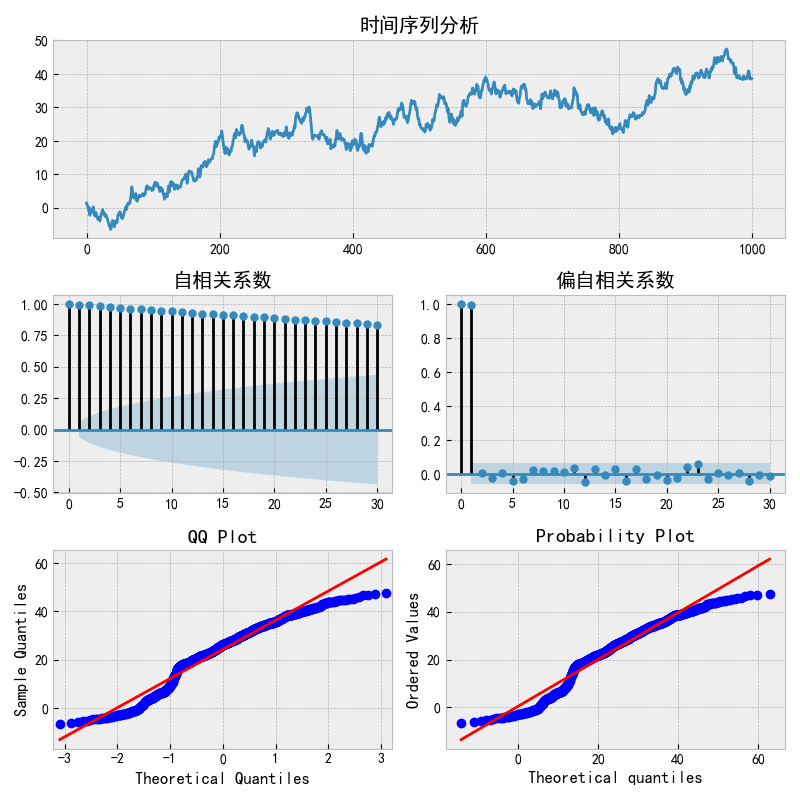

In [7]:
np.random.seed(1)
n_samples=1000
x=w=np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t]=x[t-1]+w[t]
tsplot(x,lags=30)

<IPython.core.display.Javascript object>


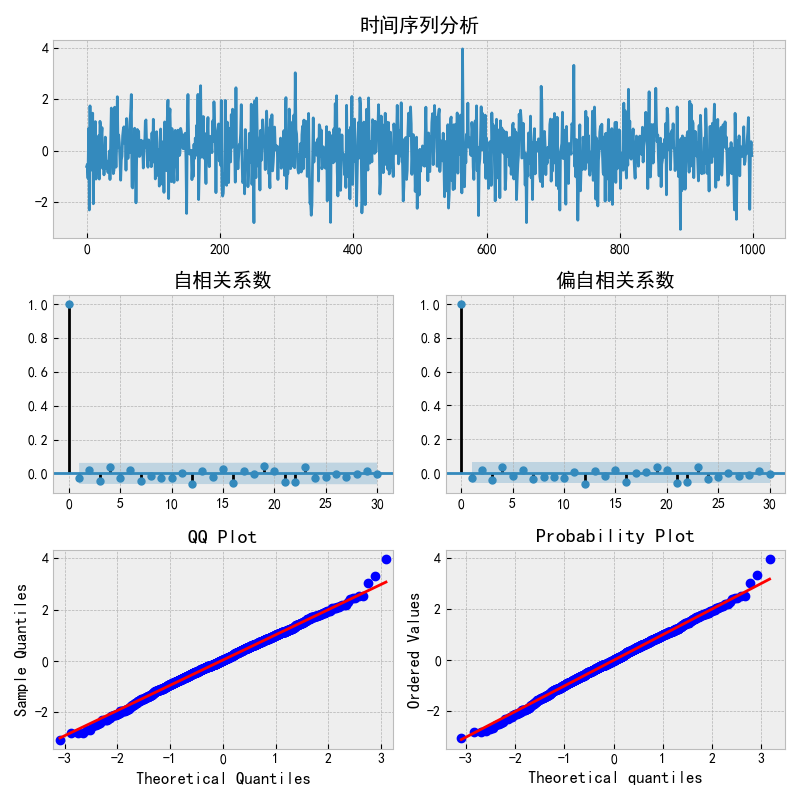

In [8]:
tsplot(np.diff(x),lags=30)

<IPython.core.display.Javascript object>


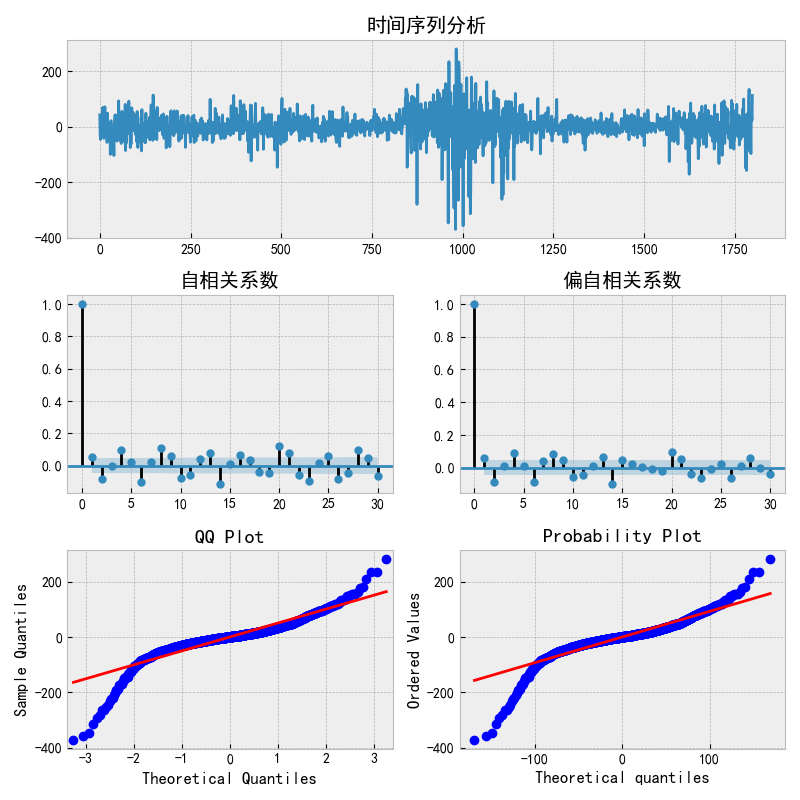

In [9]:
tsplot(np.diff(data.hs300),lags=30)

# 线性模型
线性模型又称趋势模型表示可以使用直线绘制的TS。基本等式是：$y_t=b_0+b_1t+ϵ_t$

<IPython.core.display.Javascript object>


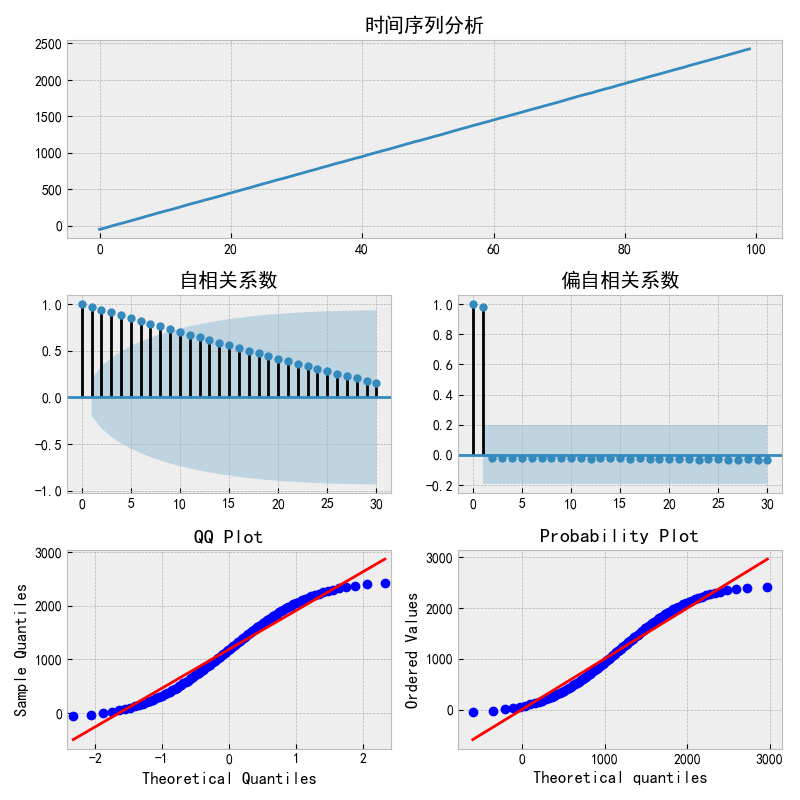

In [10]:
w=np.random.randn(100)
y=np.empty_like(w)
b0=-50
b1=25
for t in range(len(w)):
    y[t]=b0+b1*t+w[t]
tsplot(y,lags=30)

# 对数线性模型

<IPython.core.display.Javascript object>


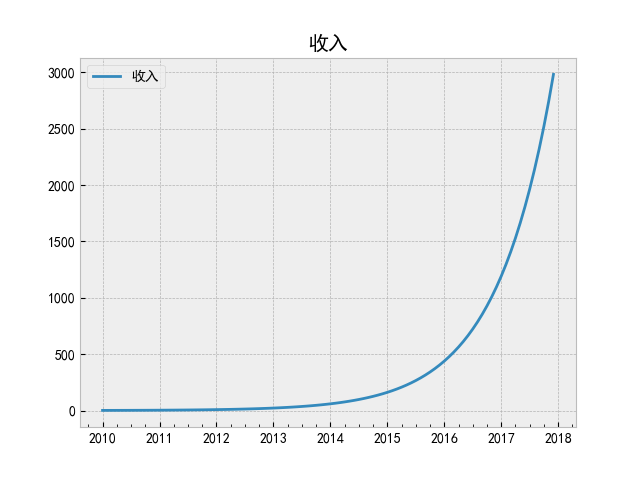

In [11]:
idx=pd.date_range('2010-01-01','2018-01-01',freq="M")
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]
df = pd.DataFrame(sales, columns=['收入'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('收入')

<IPython.core.display.Javascript object>


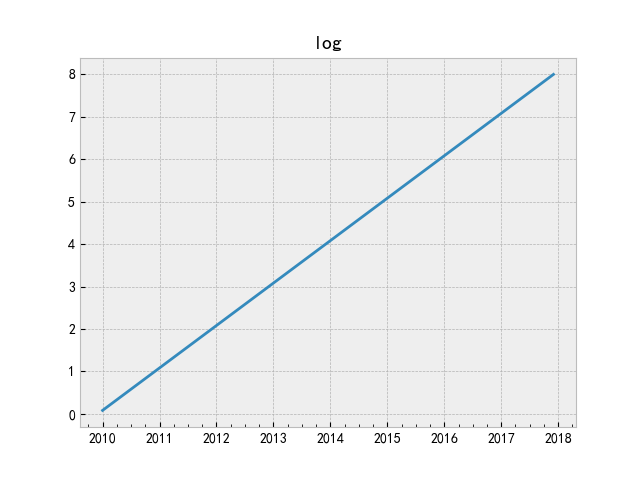

In [12]:
plt.figure()
with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('log')

# 自回归模型$-AR(P)$
当因变量针对其自身的一个或多个滞后值进行回归时，该模型称为自回归。公式如下：<br>$x_t=μ+∑_{i=1}^p{ϕ_i x_{t-i}}+ε_t=ϕ_0+ϕ_1 x_{t-1}+ϕ_2 x_{t-2},…,ϕ_p x_{t-p}+ε_t$
随机游走时间序列：$x_t=ϕ_0+x_{t-1}+ε_t$

<IPython.core.display.Javascript object>


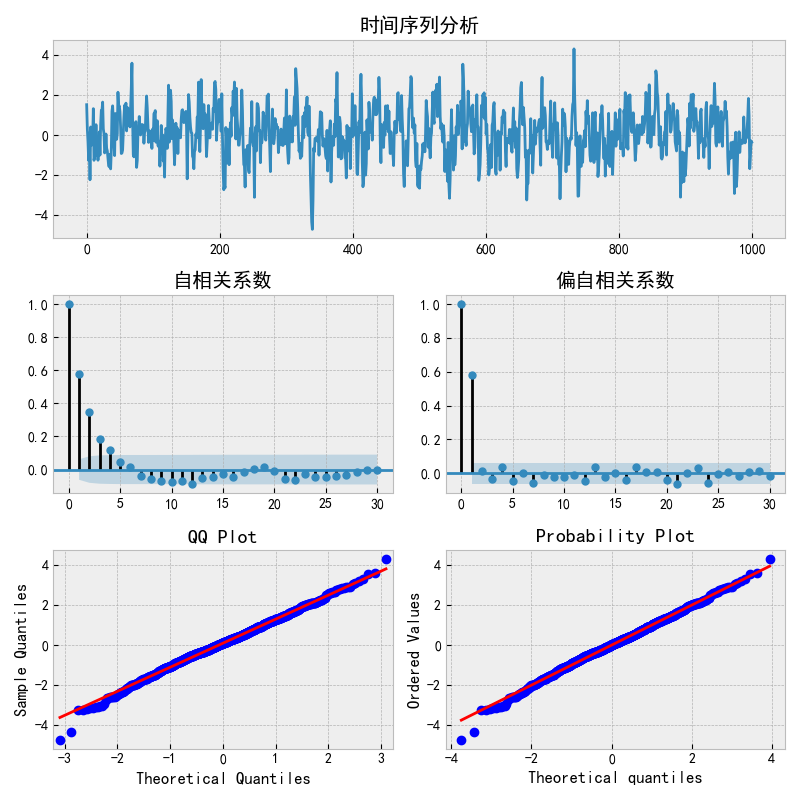

In [13]:
np.random.seed(1)
n_samples=1000
a=.6
x=w=np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t]=a*x[t-1]+w[t]
tsplot(x,lags=30)

In [14]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')
true_order = 1
p('\nα估计值: {:3.5f} | 最优阶数= {}'
  .format(mdl.params[0], est_order))
p('\nα真实值: {} | 真实阶数= {}'
  .format(a, true_order))

Wall time: 14.2 s

α估计值: 0.58227 | 最优阶数= 1

α真实值: 0.6 | 真实阶数= 1


<IPython.core.display.Javascript object>


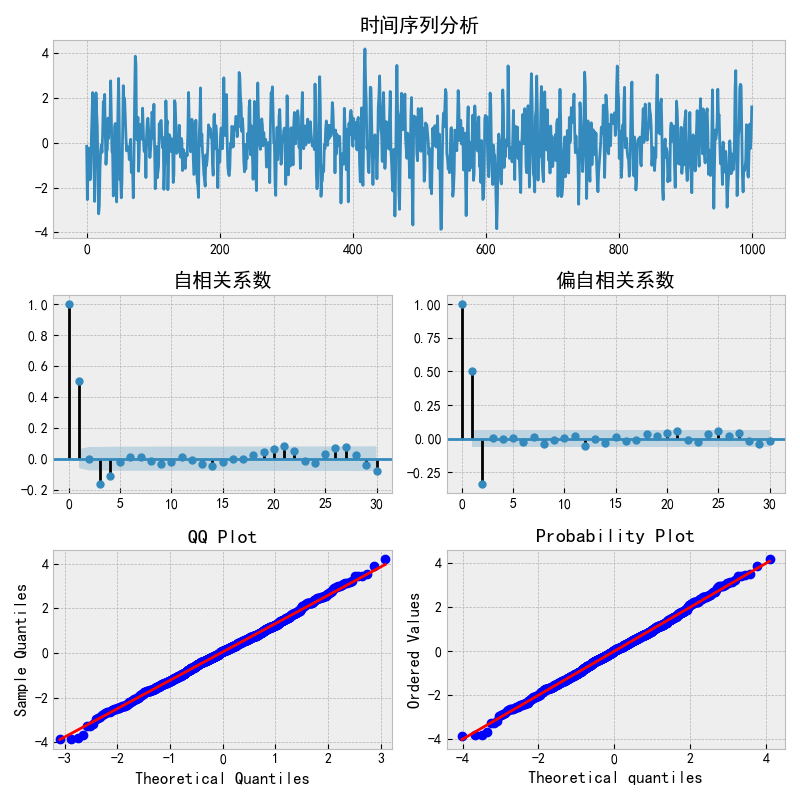

In [15]:
n=1000
alphas=np.array([2/3,-1/3])
betas=np.array([0.])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ar2, lags=30)

In [16]:
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\n估计系数: {:3.4f} {:3.4f} | 最优阶数 = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\n真实系数 = {} | 真实阶数 = {}'
  .format([.666,-.333], true_order))


估计系数: 0.6767 -0.3396 | 最优阶数 = 2

真实系数 = [0.666, -0.333] | 真实阶数 = 2


<IPython.core.display.Javascript object>


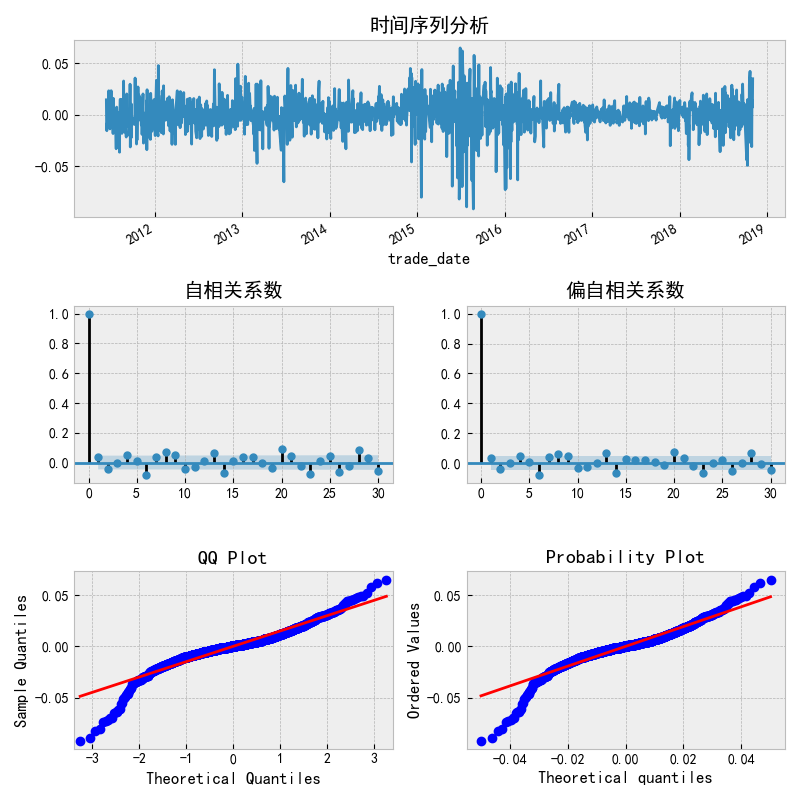

In [17]:
tsplot(lrets.hs300, lags=30)

In [18]:
max_lag = 30
mdl = smt.AR(lrets.hs300).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.hs300).select_order(maxlag=max_lag, ic='aic', trend='nc')
p('最优阶数 = {}'.format(est_order))

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


最优阶数 = 30


# 移动平均模型$-MA(q)$

<IPython.core.display.Javascript object>


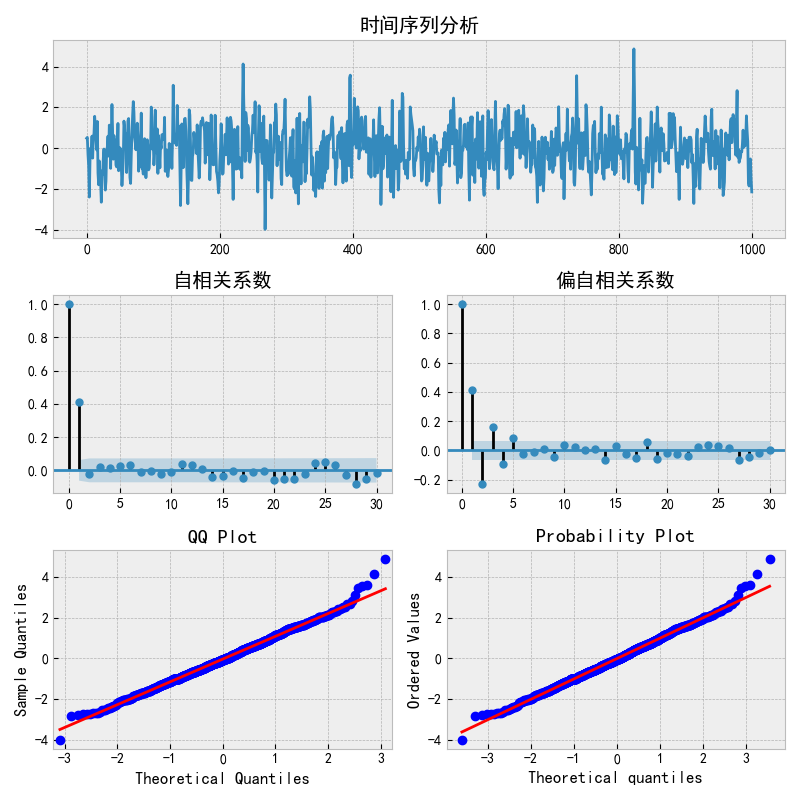

In [19]:
n=1000
alphas=np.array([0.])
betas=np.array([.6])
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ma1, lags=30)

In [20]:
max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Sun, 04 Nov 2018   AIC                           2785.025
Time:                        17:00:07   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                  Real          Imaginary           M

<IPython.core.display.Javascript object>


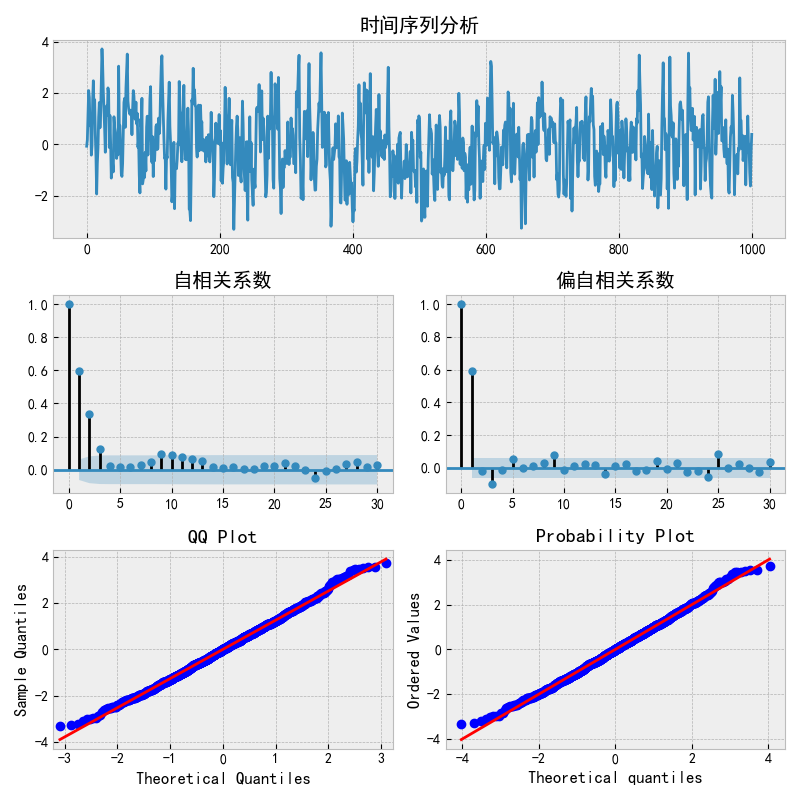

In [21]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma3, lags=30)

In [22]:
max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Sun, 04 Nov 2018   AIC                           2862.075
Time:                        17:00:07   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

                              ARMA Model Results                              
Dep. Variable:                  hs300   No. Observations:                 1799
Model:                     ARMA(0, 3)   Log Likelihood                5016.368
Method:                           mle   S.D. of innovations              0.015
Date:                Sun, 04 Nov 2018   AIC                         -10024.736
Time:                        17:00:07   BIC                         -10002.756
Sample:                             0   HQIC                        -10016.622
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ma.L1.hs300     0.0364      0.024      1.530      0.126      -0.010       0.083
ma.L2.hs300    -0.0383      0.023     -1.688      0.092      -0.083       0.006
ma.L3.hs300    -0.0090      0.026     -0.347    

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<IPython.core.display.Javascript object>


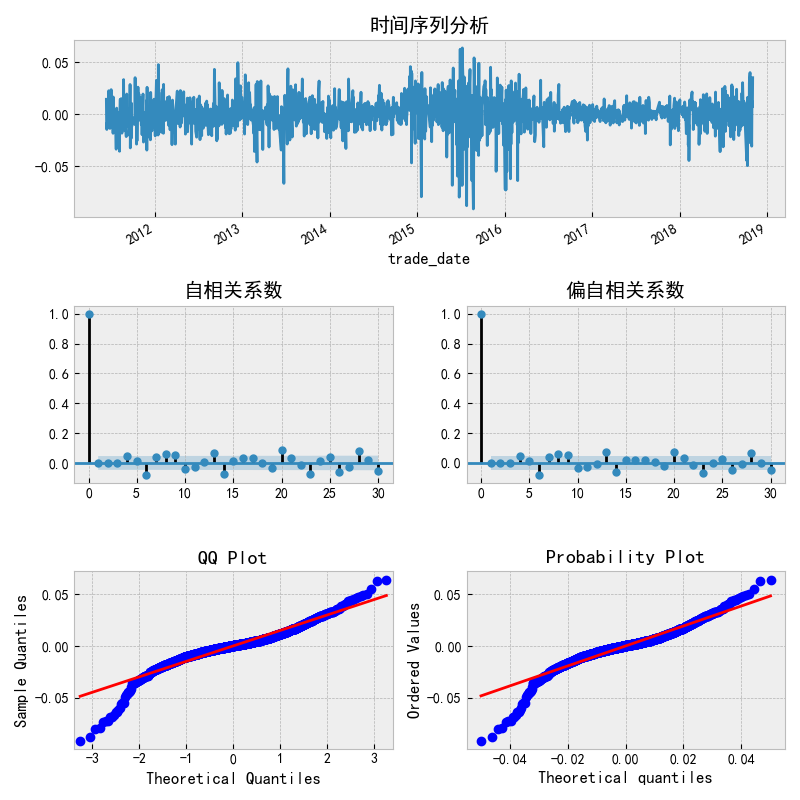

In [23]:
max_lag = 30
Y = lrets.hs300
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
tsplot(mdl.resid, lags=max_lag)

# 自回归移动平均模型 $- ARMA（p，q）$

<IPython.core.display.Javascript object>


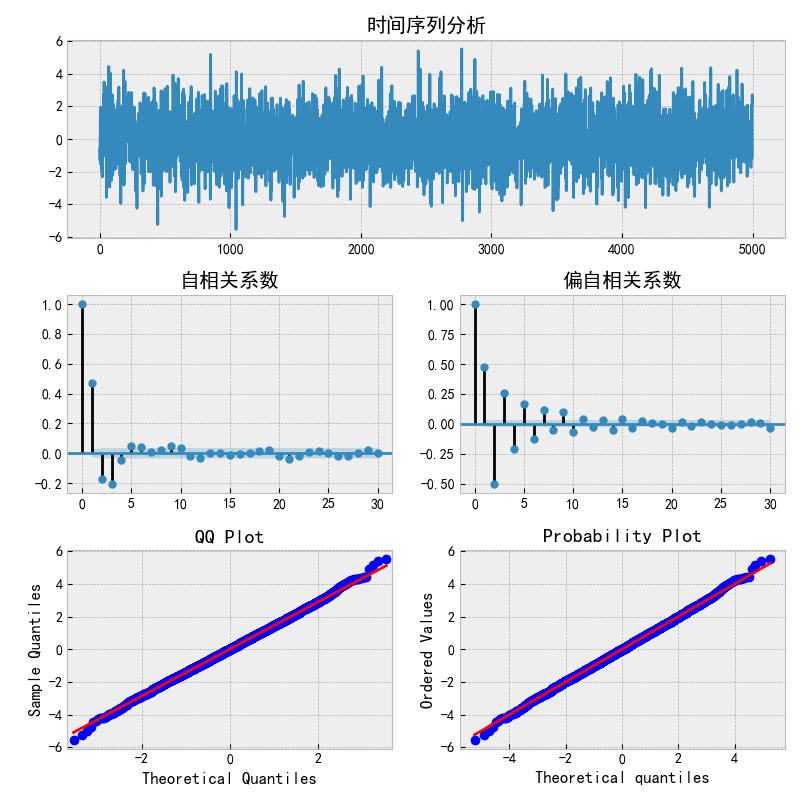

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Sun, 04 Nov 2018   AIC                          14162.352
Time:                        17:00:08   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

<IPython.core.display.Javascript object>


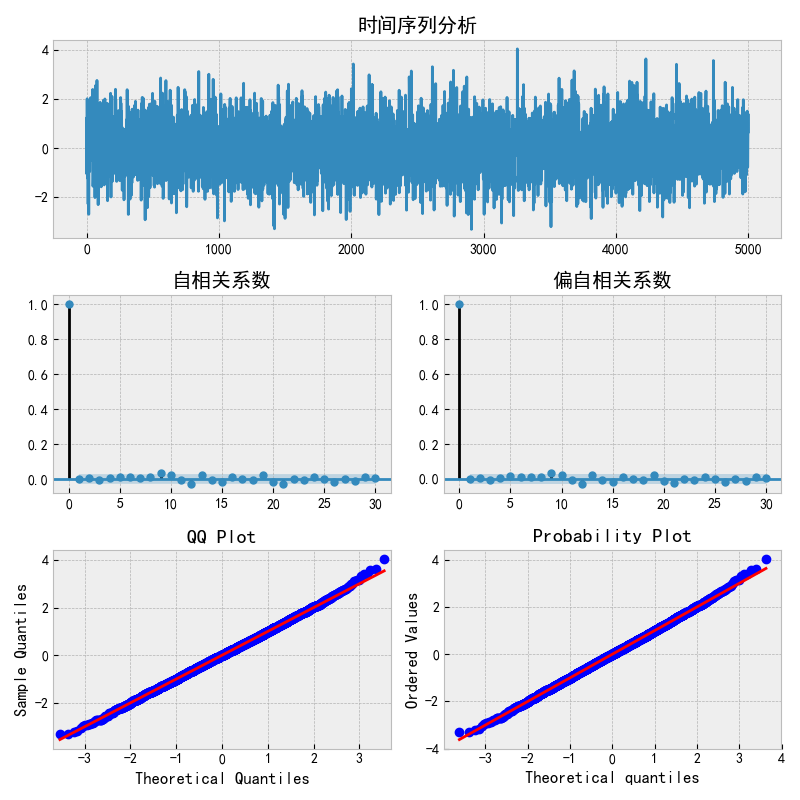

In [24]:
# 我们估计出了模型以及对应的滞后阶数，取估计模型系数的情况
n=5000
burn = int(n/10)
alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)
mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())
tsplot(mdl.resid, lags=max_lag)

<IPython.core.display.Javascript object>


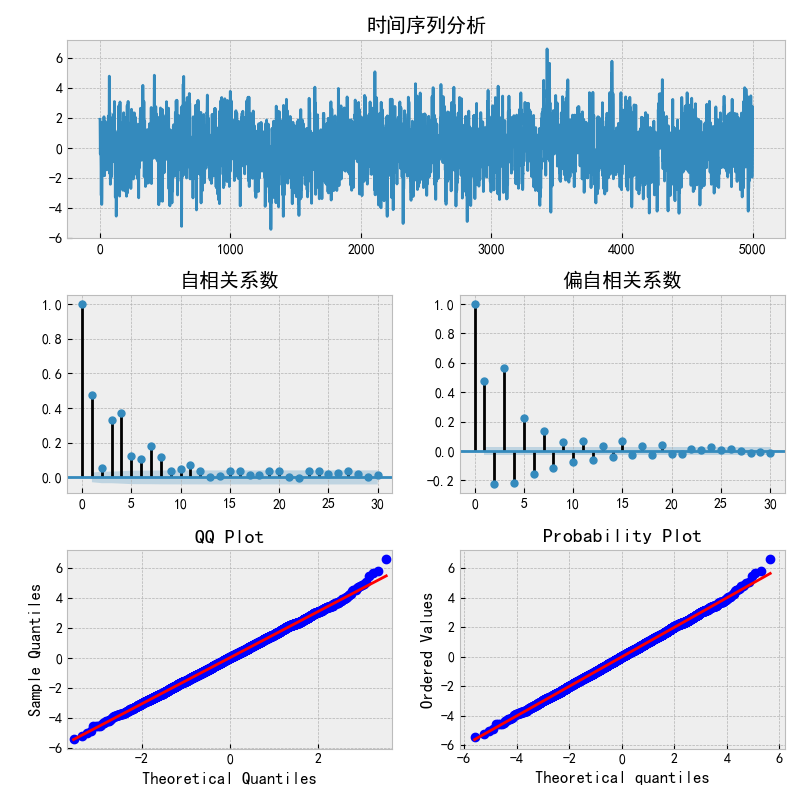

In [25]:
# 估计模型的阶数和系数
max_lag = 30
n = int(5000)
burn = 2000
alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma32, lags=max_lag)

In [26]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue
p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 14212.01026 | order: (3, 2)


In [27]:
p(best_mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7100.005
Method:                           mle   S.D. of innovations              1.001
Date:                Sun, 04 Nov 2018   AIC                          14212.010
Time:                        17:00:30   BIC                          14251.113
Sample:                             0   HQIC                         14225.715
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5254      0.027     19.388      0.000       0.472       0.579
ar.L2.y       -0.2634      0.016    -16.458      0.000      -0.295      -0.232
ar.L3.y        0.4307      0.014     31.615      0.0

<IPython.core.display.Javascript object>


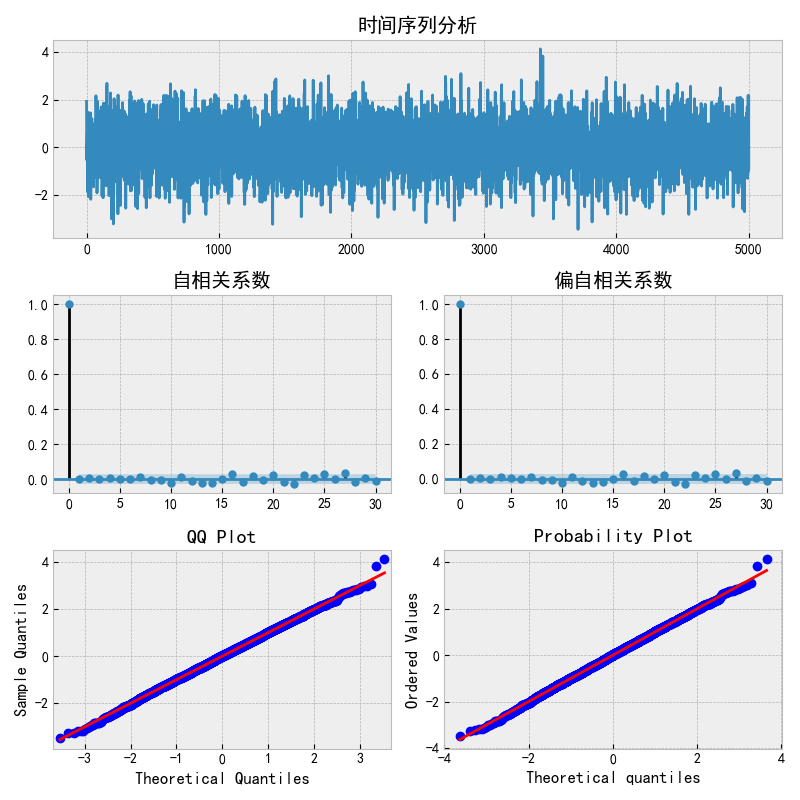

In [28]:
tsplot(best_mdl.resid, lags=max_lag)

In [29]:
# 求沪深300对数收益率的最优模型
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets.hs300, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue
p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

aic: -10062.32155 | order: (3, 2)


In [30]:
p(best_mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                  hs300   No. Observations:                 1799
Model:                     ARMA(3, 2)   Log Likelihood                5037.161
Method:                           mle   S.D. of innovations              0.015
Date:                Sun, 04 Nov 2018   AIC                         -10062.322
Time:                        17:00:41   BIC                         -10029.352
Sample:                             0   HQIC                        -10050.151
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.hs300     0.1962      0.048      4.047      0.000       0.101       0.291
ar.L2.hs300    -0.9658      0.017    -58.311      0.000      -0.998      -0.933
ar.L3.hs300     0.0600      0.027      2.243    

<IPython.core.display.Javascript object>


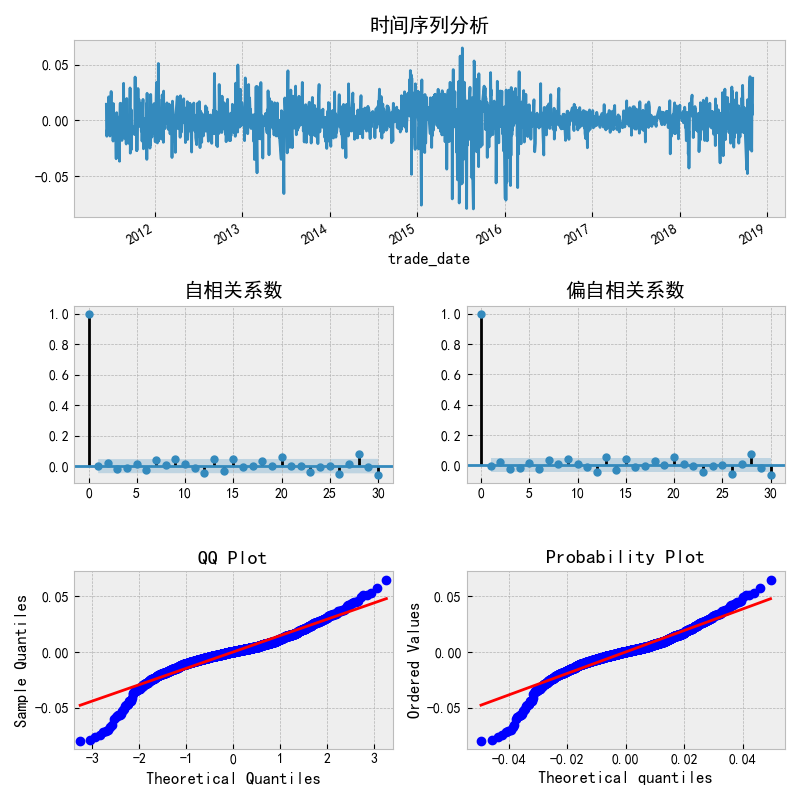

In [31]:
tsplot(best_mdl.resid, lags=max_lag)

# 自回归整合移动平均模型 $- ARIMA（p，d，q）$

In [32]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.hs300, order=(i,d,j)).fit(method='mle', trend='nc',)
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

aic: -10062.32155 | order: (3, 0, 2)


<IPython.core.display.Javascript object>


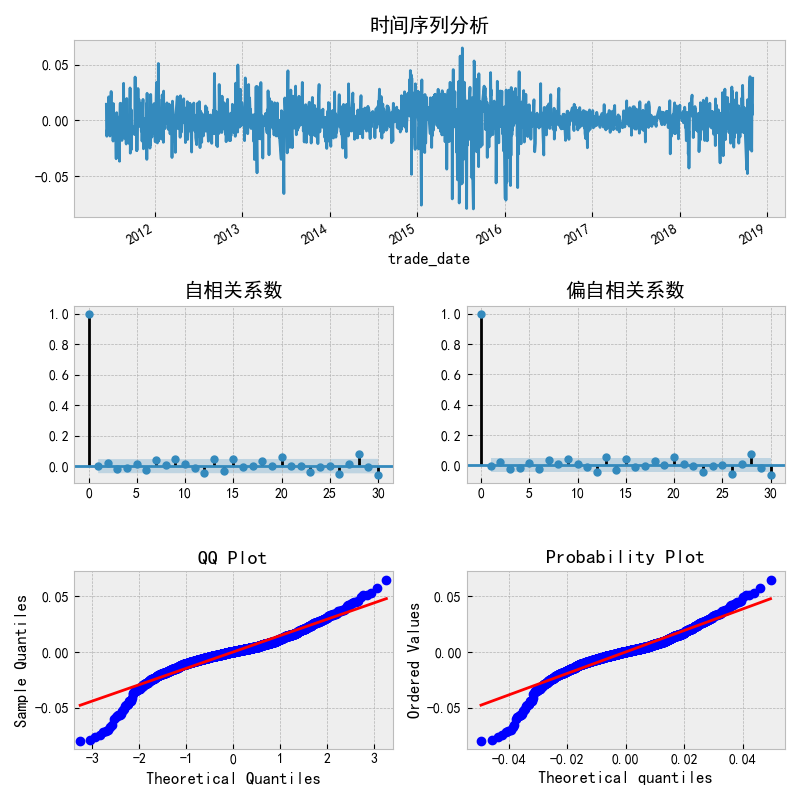

In [33]:
tsplot(best_mdl.resid, lags=30)

In [34]:
# 预测
n_steps = 21
f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI
idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2018-11-02,-0.000610,-0.029448,-0.038509,0.028227,0.037289
2018-11-03,0.001470,-0.027385,-0.036452,0.030325,0.039392
2018-11-04,0.002980,-0.025895,-0.034968,0.031855,0.040928
2018-11-05,-0.000872,-0.029751,-0.038826,0.028008,0.037083
2018-11-06,-0.002961,-0.031865,-0.040948,0.025944,0.035027


<IPython.core.display.Javascript object>


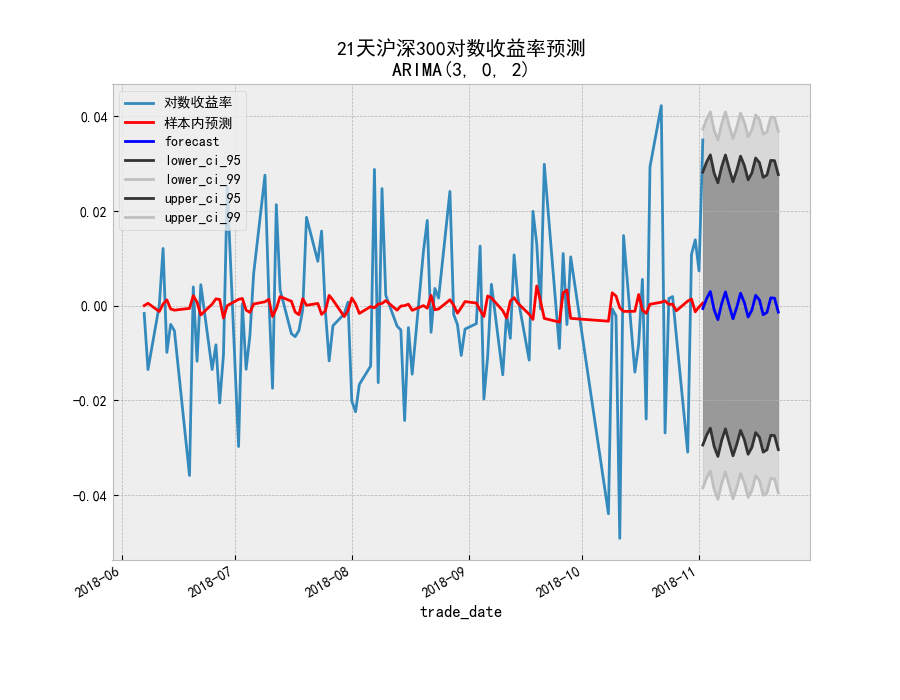

In [35]:
# 预测绘图
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()
ts = lrets.hs300.iloc[-100:].copy()
ts.plot(ax=ax, label='对数收益率')
pred = best_mdl.predict(start=0, end=ts.index.shape[0]-1)
pred.index=ts.index
pred.plot(ax=ax,label='样本内预测', style='r-')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{}天沪深300对数收益率预测\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)